## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [155]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def plot_images(imgs, titles):

    j_plots = 2
    i_plots = len(imgs) // j_plots

    fig, axes = plt.subplots(i_plots+2, j_plots, figsize=(20, 10))
    plt.tight_layout(pad=0.4, w_pad=1, h_pad=2.0)
    #print(axes.shape, i_plots, j_plots)  
    
    i = 0

    for img in imgs:
        if len(img.shape) == 3:
            axes[i//j_plots, i%j_plots].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            axes[i//j_plots, i%j_plots].imshow(img, cmap='gray')
            
        if len(titles) != 0:
            axes[i//j_plots, i%j_plots].set_title(titles[i])
        i += 1
        
    return


def calibrate_camera(img_fnames):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    nx = 9
    ny = 6
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    imgs = []
    titles = []

    # Step through the list and search for chessboard corners
    for fname in img_fnames:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img_chess = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)

            imgs.append(img_chess)
            titles.append(fname.split('/')[-1])
            #plt.show()
            #cv2.waitKey(500)

    #cv2.destroyAllWindows()
    plot_images(imgs, titles)
    
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[ : :-1], None, None)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    plot_images([undist], ['undist'])
    
    return mtx, dist


def thresholding_for_lane(img, sobel_kernel=3, x_thresh=(20, 100), y_thresh=(20, 100), 
                          mag_thresh=(30, 100), dir_thresh=(0, np.pi/2),
                         s_thresh=(170, 255), plot=False):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) 
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) 
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)    
    
    def scaled_255(binary):
        return np.uint8(binary/np.max(binary)*255)
    
    scaled_sobelx = scaled_255(abs_sobelx)
    scaled_sobely = scaled_255(abs_sobely)
    scaled_sobelm = scaled_255(mag_sobel)
    
    def mag_threshold():
        return (scaled_sobelm > mag_thresh[0]) & (scaled_sobelm <= mag_thresh[1])
    def x_threshold():
        return (scaled_sobelx > x_thresh[0]) & (scaled_sobelx <= x_thresh[1])
    def y_threshold():
        return (scaled_sobely > y_thresh[0]) & (scaled_sobely <= y_thresh[1])
    
    def dir_threshold():
        return (dir_sobel > dir_thresh[0]) & (dir_sobel <= dir_thresh[1])
    
    combined = np.zeros_like(gray)
    combined[((x_threshold() == 1) & (y_threshold() == 1)) 
             | ((mag_threshold() == 1) & (dir_threshold() == 1))] = 1
    if plot:
        plot_images([combined], ['gradient_thresh'])   
    
    
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]

    combined_c = np.zeros_like(gray)
    combined_c[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    if plot:
        plot_images([combined_c], ['color_thresh'])
    
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(combined), scaled_255(combined), scaled_255(combined_c)))
    if plot:
        plot_images([color_binary], ['color_dstack'])
    
    combined[(combined == 1)
             | (s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    if plot:
        plot_images([combined], ['combined'])
    
    return combined



## And so on and so forth...

array([[[154, 149, 150],
        [153, 148, 149],
        [153, 148, 149],
        ..., 
        [116, 116, 116],
        [116, 116, 116],
        [116, 116, 116]],

       [[154, 149, 150],
        [154, 149, 150],
        [154, 149, 150],
        ..., 
        [116, 116, 116],
        [116, 116, 116],
        [116, 116, 116]],

       [[152, 147, 148],
        [153, 148, 149],
        [154, 149, 150],
        ..., 
        [116, 116, 116],
        [116, 116, 116],
        [115, 115, 115]],

       ..., 
       [[131, 128, 130],
        [132, 129, 131],
        [132, 129, 131],
        ..., 
        [113, 110, 112],
        [112, 109, 111],
        [112, 109, 111]],

       [[131, 128, 130],
        [132, 129, 131],
        [132, 129, 131],
        ..., 
        [112, 109, 111],
        [112, 109, 111],
        [112, 109, 111]],

       [[131, 128, 130],
        [132, 129, 131],
        [132, 129, 131],
        ..., 
        [113, 109, 112],
        [112, 109, 112],
        [112, 109,

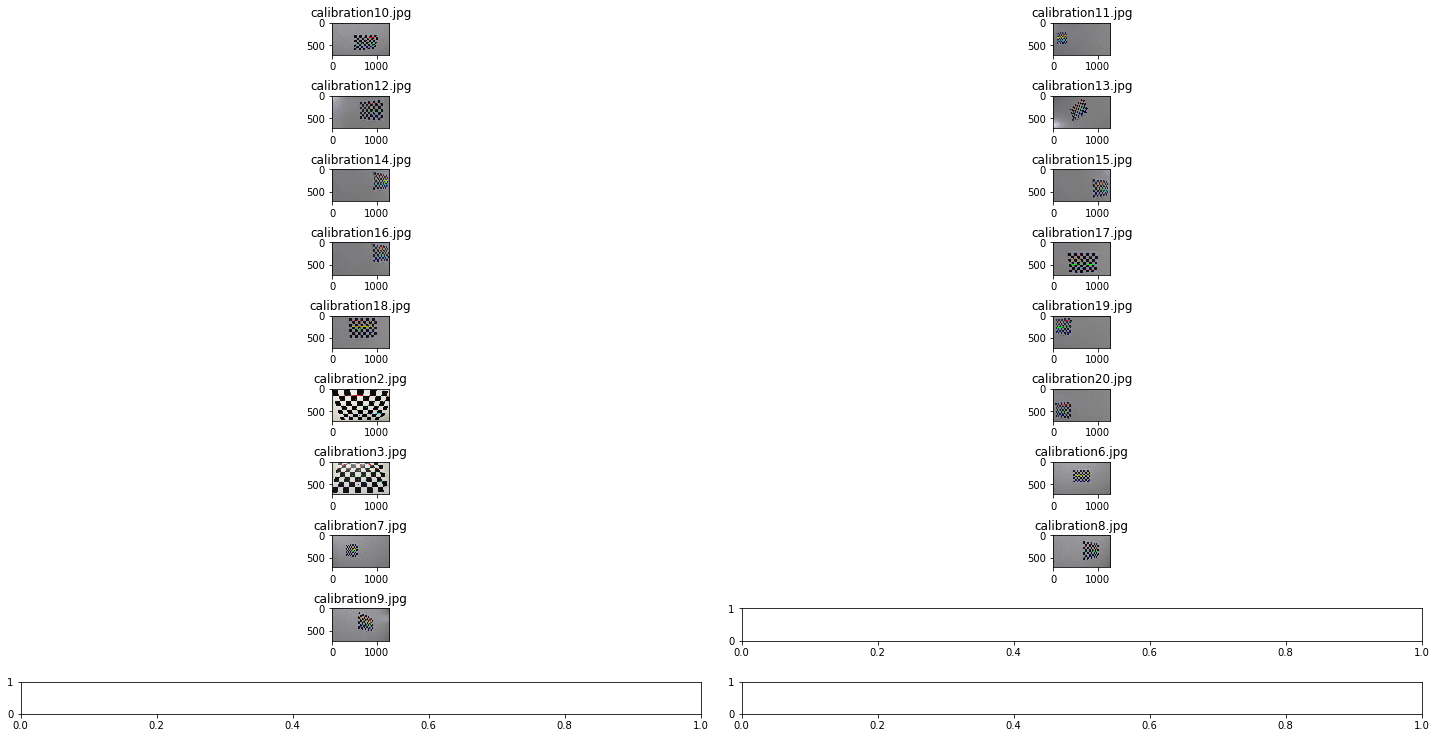

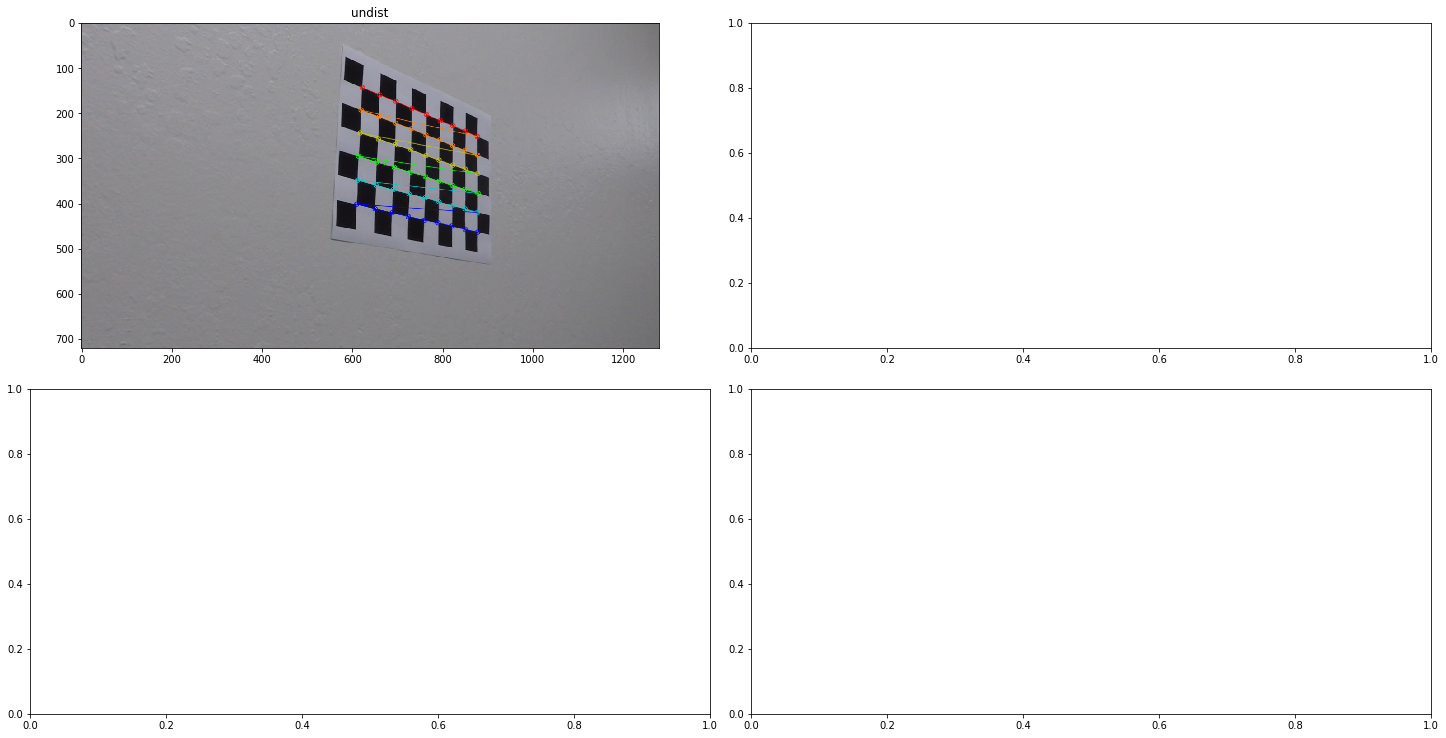

In [2]:
straight_fnames = glob.glob('../test_images/straight*.jpg')
test_fnames = glob.glob('../test_images/test*.jpg')
camera_fnames = glob.glob('../camera_cal/calibration*.jpg')

calibrate_camera(camera_fnames)

In [156]:
straight_img = cv2.imread(straight_fnames[0])
test_img = cv2.imread(test_fnames[0])

thresh_img = thresholding_for_lane(test_img, sobel_kernel=3, x_thresh=(20, 100), y_thresh=(20, 100), 
                          mag_thresh=(30, 100), dir_thresh=(0, np.pi/2))


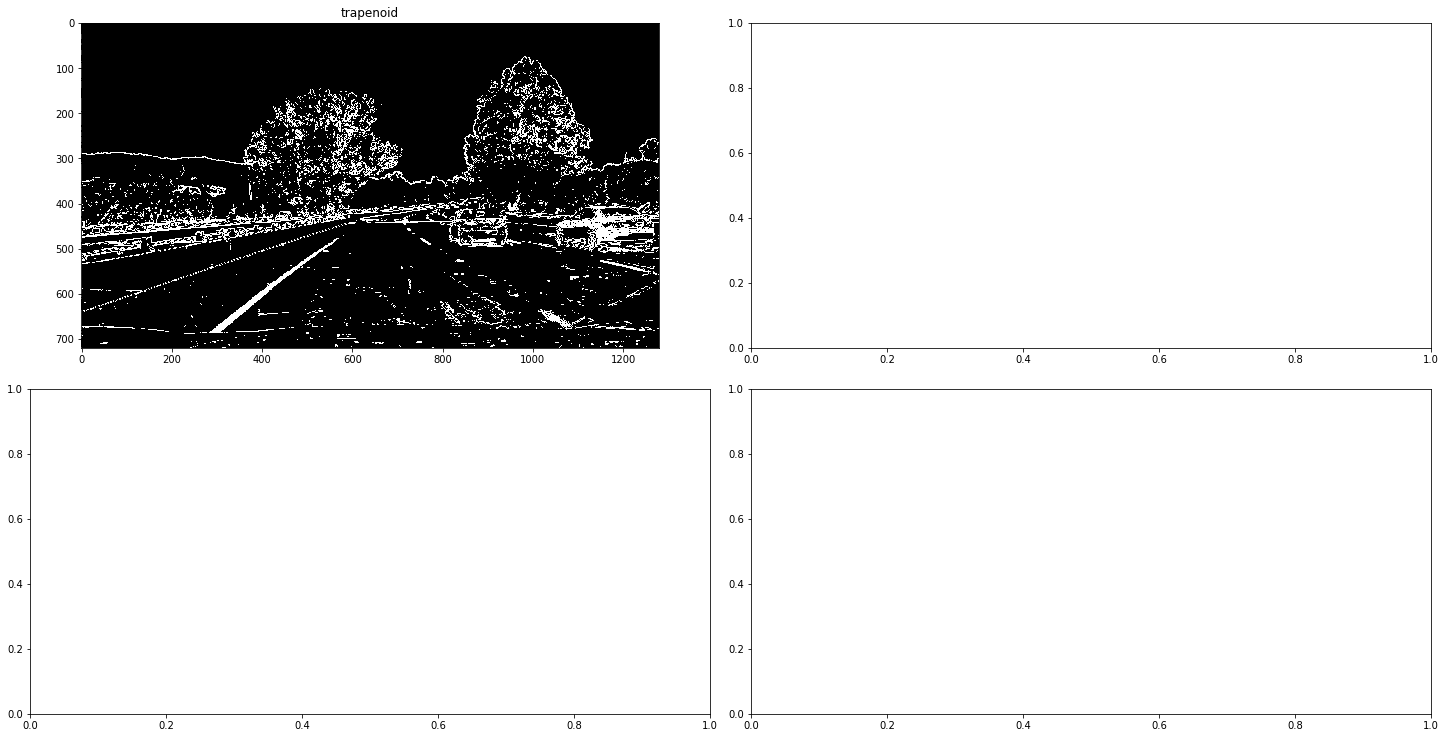

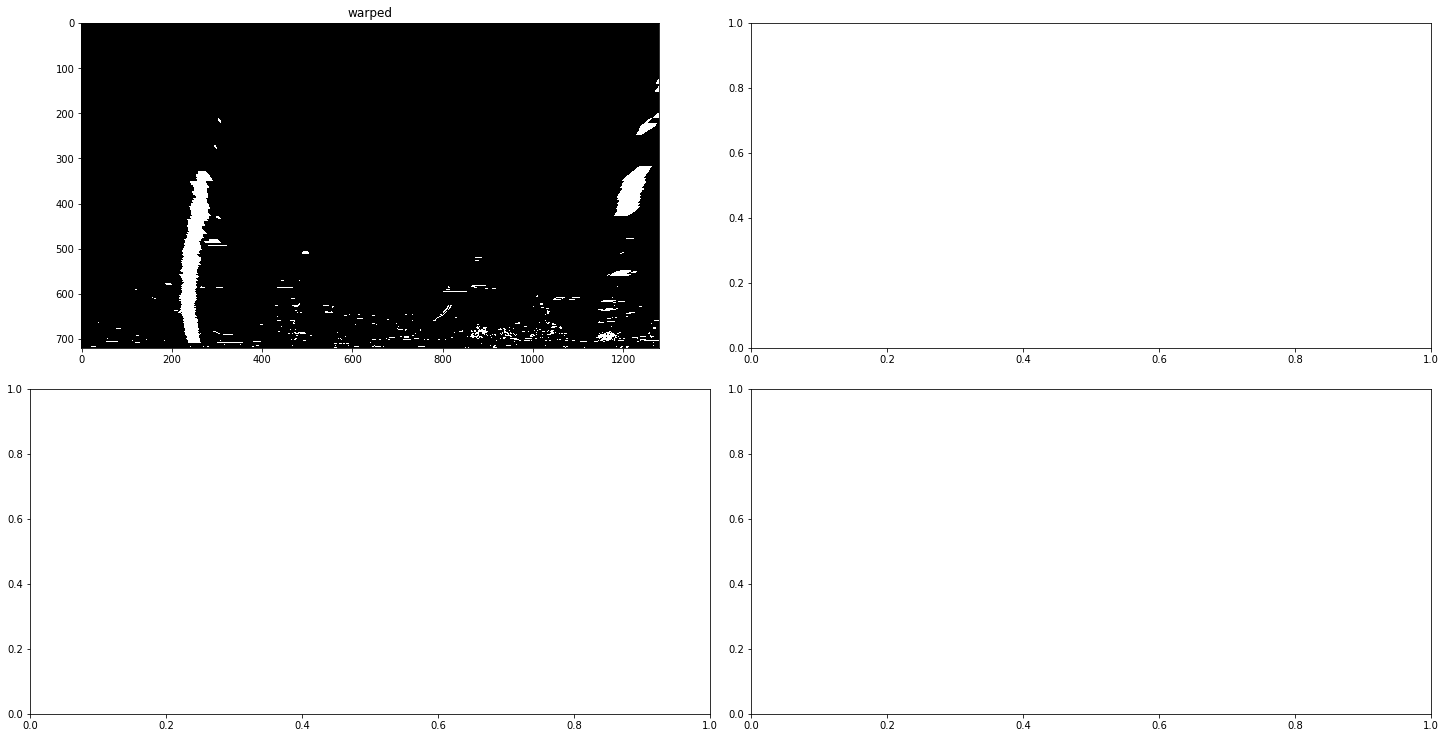

In [113]:

def perspective_for_lane(img, M, src_pts, dst_pts):
    #pts = src_pts.reshape((-1,1,2))
    #dst_pts = dst_pts.reshape((-1,1,2))
    w_img = np.copy(img)
    
    poly_pts = np.int32(src_pts)
    #cv2.polylines(w_img, [poly_pts], True, (255,255,0), thickness=2, lineType=cv2.LINE_AA)
    plot_images([w_img], ['trapenoid'])


    
    #Minv = cv2.getPerspectiveTransform(dst, src)
    h, w = img.shape[:2]
    warped = cv2.warpPerspective(w_img, M, (w,h), flags=cv2.INTER_LINEAR)
    
    poly_pts = np.int32(dst_pts)
    #cv2.polylines(warped, [poly_pts], True, (255,255,0), thickness=2, lineType=cv2.LINE_AA)    
    plot_images([warped], ['warped'])
    
    return warped



img_w = thresh_img.shape[1]
img_h = thresh_img.shape[0]

src_pts = np.array([
[img_w*(0.15),img_h],
[img_w*(0.5-0.040), img_h*(0.5+0.13)], 
[img_w*(0.5+0.040), img_h*(0.5+0.13)], 
[img_w*(1-0.15+0.01),img_h]], dtype=np.float32)

dst_pts = np.array([
[img_w*(0.15),img_h],
[img_w*(0.15), 0], 
[img_w*(1-0.15+0.01), 0], 
[img_w*(1-0.15+0.01),img_h]], dtype=np.float32)

M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    
binary_warped = perspective_for_lane(thresh_img, M, src_pts, dst_pts)


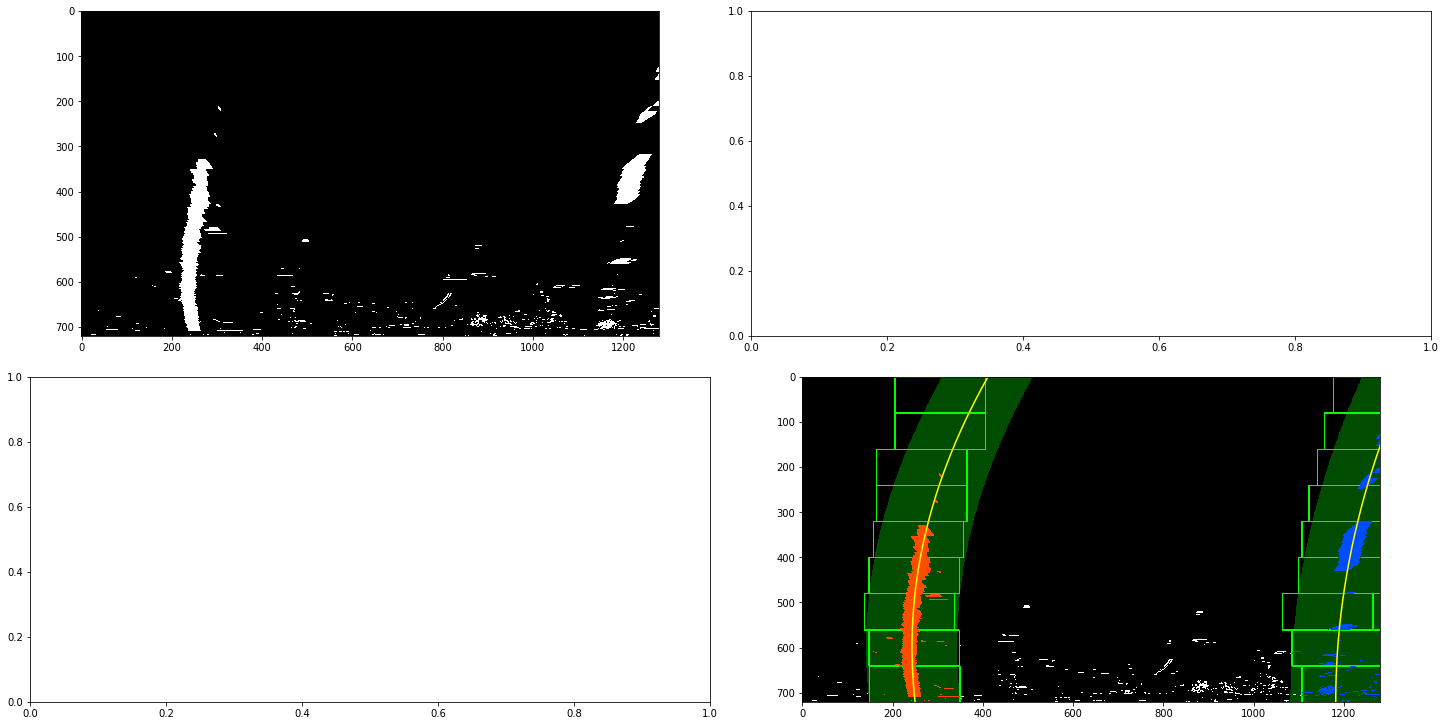

In [150]:
def sliding_window_search_for_lane(img):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one 
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin 
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,
                      (win_xleft_low,win_y_low),
                      (win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,
                      (win_xright_low,win_y_low),
                      (win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)
                         ).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)
                          ).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    window_img = np.zeros_like(out_img)
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return left_fit, right_fit

plot_images([binary_warped], [''])

left_fit, right_fit = sliding_window_search_for_lane(binary_warped)

In [159]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = thresholding_for_lane(image)
    return result
%pwd

'/Users/ohora/Documents/horagong/project/self-driving-car/CarND-Advanced-Lane-Lines/examples'

In [158]:
project_output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)





OSError: MoviePy error: the file project_video.mp4 could not be found !
Please check that you entered the correct path.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [152]:
def next_window_search_for_lane(img, left_fit, right_fit):

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100

    left_lane_inds = (
        (nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
        (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = (
        (nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
        (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit


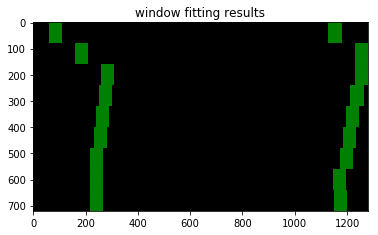

In [146]:
import matplotlib.image as mpimg

# Read in a thresholded image
#warped = mpimg.imread('warped_example.jpg')

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(win_w, win_h, img_ref, center, level):
    '''
    Window_mask is a function to draw window areas
    '''
    
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0] - (level+1)*win_h):
           int(img_ref.shape[0] - level*win_h),
           max(0, int(center-win_w/2)):
           min(int(center+win_w/2), img_ref.shape[1])] = 1
    return output

def find_window_centroids(img, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(img[int(3*img.shape[0]/4):,:int(img.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum)) - window_width/2
    
    r_sum = np.sum(img[int(3*img.shape[0]/4):,int(img.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum)) - window_width/2 + int(img.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(img.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(
            img[int(img.shape[0]-(level+1)*window_height):
                int(img.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin, 0))
        l_max_index = int(min(l_center+offset+margin, img.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index]) + l_min_index - offset
        
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin, 0))
        r_max_index = int(min(r_center+offset+margin, img.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index]) + r_min_index - offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(binary_warped)
    r_points = np.zeros_like(binary_warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        
        l_mask = window_mask(window_width, window_height,
                             binary_warped, window_centroids[level][0], level)
        r_mask = window_mask(window_width, window_height,
                             binary_warped, window_centroids[level][1], level)
        
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points + l_points, np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template)  
    template = np.array(cv2.merge((zero_channel, template, zero_channel)),np.uint8)
    warpage = np.array(cv2.merge((binary_warped, binary_warped, binary_warped)),np.uint8) 
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) 
  
else:
    output = np.array(cv2.merge((binary_warped, binary_warped, binary_warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()